### Bootstrap

#### Using

In [40]:
#r "nuget: Microsoft.Data.Analysis, 0.21.1"
#r "nuget: ScottPlot, 5.0.36"

using System;
using System.Reflection;

using Microsoft.DotNet.Interactive.Formatting;

using Microsoft.Data.Analysis;

using Newtonsoft.Json;

bool DEBUG = true;

Installed Packages Microsoft.Data.Analysis, 0.21.1 ScottPlot, 5.0.36

#### Plots & Logs

In [62]:
Formatter.Register(typeof(ScottPlot.Plot), (p, w) => w.Write(((ScottPlot.Plot)p).GetImageHtml(400, 300)), HtmlFormatter.MimeType);
Formatter.Register(typeof(ScottPlot.Plot[]), (ps, w) =>  {
    var style = @"<style> .array-container { display: flex; flex-wrap: wrap; gap: 5px; } .array-item { border: 1px solid #ccc; } </style>";
    var grid = ((ScottPlot.Plot[])ps).Select(plot => $"<div class='array-item'>{plot.GetImageHtml(400, 300)}</div>");
    w.Write($"{style}<div class='array-container'>{String.Join(" ", grid)}</div>");
}, HtmlFormatter.MimeType);

class PlotBuilder {
    ScottPlot.Plot plot;

    public PlotBuilder (string title = "") {
        plot = new ();
        plot.Axes.Title.Label.Text = title;
        plot.Legend.Alignment = ScottPlot.Alignment.UpperLeft;
        plot.Legend.ShadowOffset = new (1,1);
    }

    public PlotBuilder Add<T1, T2> (IEnumerable<T1> x, IEnumerable<T2> y, string legend = default) {
        var scatter = plot.Add.Scatter(x.ToList(), y.ToList());
        scatter.LegendText = legend ?? "";
        scatter.LineWidth = 1;
        scatter.MarkerSize = 0;
        return this;
    }
    public PlotBuilder Add<T> (IEnumerable<T> y, string legend = default) => Add(Enumerable.Range(0, y.Count()), y, legend);
    public PlotBuilder Add<T> (IEnumerable<(T,T)> y, (string, string) legend = default) =>
         Add(y.Select(y => y.Item1), legend.Item1)
        .Add(y.Select(y => y.Item2), legend.Item2);
    public PlotBuilder Add<T> (IEnumerable<(T,T,T)> y, (string, string, string) legend = default) => 
         Add(y.Select(y => y.Item1), legend.Item1)
        .Add(y.Select(y => y.Item2), legend.Item2)
        .Add(y.Select(y => y.Item3), legend.Item3);
    public PlotBuilder Add<T> (IEnumerable<(T,T,T,T)> y, (string, string, string, string) legend = default) => 
         Add(y.Select(y => (y.Item1, y.Item2, y.Item3)), (legend.Item1, legend.Item2, legend.Item3))
        .Add(y.Select(y => y.Item4), legend.Item4);

    public PlotBuilder LimitY(double y0, double y1) {
        plot.Axes.SetLimitsY(y0, y1);
        return this;
    } 
    public PlotBuilder Limit(double x0, double x1, double y0, double y1) {
        plot.Axes.SetLimits(x0, x1, y0, y1);
        return this;
    }
    public PlotBuilder LimitH(double h) => LimitY(0, h); 

    public ScottPlot.Plot Build () => plot;
}

In [42]:
static string DumpS(this object value) => value is not string ? JsonConvert.SerializeObject(value, Formatting.None) : value as string;

static T[] DumpMulti<T> (this T[] values) {
    values.ToList().ForEach(item => item.Dump());
    return values;  
} 
static IEnumerable<T> DumpMulti<T> (this IEnumerable<T> values) {
    values.ToList().ForEach(item => item.Dump());
    return values;
} 
static T Dump<T>(this T value) => DumpOneLine(value);

static T DumpOneLine<T> (this T value) {
    Console.WriteLine(value.DumpS());
    return value;
}
static void Log(this object item) => Console.WriteLine(item);

In [43]:
static BindingFlags flags = BindingFlags.Public | BindingFlags.Instance;

static DataFrame CreateDataFrame (IEnumerable<object> values) {
    Type type = values.First().GetType();

    if (type.IsPrimitive)
        return DataFrame.LoadFrom(values.Select(i => new List<object>() { i }), new List<(string, Type)>() { ("", type)});

    FieldInfo[] fields = type.GetFields(flags);
    PropertyInfo[] properties = type.GetProperties(flags);

    IEnumerable<DataFrame> dataFields = fields.Select(field => CreateDataFrame(values.Select(field.GetValue)).AddPrefix($"{field.Name} ", inPlace: true));
    IEnumerable<DataFrame> dataProperties = properties.Select(property => CreateDataFrame(values.Select(property.GetValue)).AddPrefix($"{property.Name} ", inPlace: true));
    IEnumerable<DataFrameColumn> columns = new [] { dataFields, dataProperties }.SelectMany(frames => frames).SelectMany(frame => frame.Columns);
    return new DataFrame(columns);
}
static DataFrame CreateDataFrame<T> (IEnumerable<T> values) => CreateDataFrame(values.Select(i => (object)i));

static DataFrame ToDataFrame<T>(this IEnumerable<T> objects, params (int index, string name)[] names) {
    FieldInfo[] fields = typeof(T).GetFields();

    string[] prefixes = new string[fields.Length];
    foreach (var t in names) 
        prefixes[t.index] = t.name;

    IEnumerable<DataFrame> dataFrames = fields.Select((field, i) => CreateDataFrame(objects.Select(obj => field.GetValue(obj))).AddPrefix(prefixes[i], inPlace: true));
    IEnumerable<DataFrameColumn> columns = dataFrames.SelectMany(df => df.Columns);

    return new DataFrame(columns);
} 
static DataFrame ToDataFrame<T>(this IEnumerable<T> objects, string prefix = "")    => CreateDataFrame(objects.ToList()).AddPrefix(prefix, inPlace: true); 
static DataFrame ToDataFrame<T>(this List<T> objects, string prefix = "")           => CreateDataFrame(objects).AddPrefix(prefix, inPlace: true); 
static DataFrame Concat(this DataFrame df, DataFrame added, string prefix = "" )    => new DataFrame(df.Columns.Concat(added.Clone().AddPrefix(prefix).Columns));

#### Random

In [44]:
Random random = new Random(29);

float NextGauss (float mean, float stdDev) {
    float u1 = 1.0f - random.NextSingle();
    float u2 = 1.0f - random.NextSingle();
    float randStdNormal = (float)Math.Sqrt(-2.0f * Math.Log(u1)) * (float)Math.Sin(2.0f * Math.PI * u2); 
    float randNormal = mean + stdDev * randStdNormal; 
    return randNormal;
}
float NextGauss (float mu, float sigma, float min, float max) {
    float x;
    do
    {
        x = NextGauss(mu, sigma);
    } while (x < min || x > max);

    return x;
}

### Simulation

#### Structs

In [21]:
using number_t = float;

public struct Market
{
    public number_t Food, Oxygen, Minerals, Water;
}

public struct MarketF
{
    public float Food, Oxygen, Minerals, Water;
}
public struct PopulationF {
    public float Farmers, Laborers, Engineers;
}

public struct Population
{
    public number_t Farmers, Laborers, Engineers;
    public number_t Children;
    public number_t Unemployed;
    public number_t Total => Farmers + Laborers + Engineers + Children + Unemployed;
    //public float FarmersNeed, LaborersNeed, EngineersNeed;
}

public struct Infrastructure 
{
    // local is air water and rail
    public number_t Rail, Space;
}
public struct Technology 
{
    public float Input, Output, Specialists;
}

public struct Points 
{
    public int Value;
}

struct SimulationState {
    public Market Market;
    public Market Surplus;
    public MarketF Ratio;
    public Population Population;
    public Infrastructure Infrastructure;
    public Technology Technology;
}

##### Helpers

In [76]:
static Market sub(Market a, Market b) => new Market
{
    Food     = a.Food     - b.Food,
    Oxygen   = a.Oxygen   - b.Oxygen,
    Minerals = a.Minerals - b.Minerals,
    Water    = a.Water    - b.Water
};
static MarketF divF(Market a, Market b) => new MarketF
{
    Food     = (float) a.Food     / b.Food,
    Oxygen   = (float) a.Oxygen   / b.Oxygen,
    Minerals = (float) a.Minerals / b.Minerals,
    Water    = (float) a.Water    / b.Water
};
static Market min (Market a, Market b) => new Market
{
    Food     = Math.Min(a.Food,     b.Food),
    Oxygen   = Math.Min(a.Oxygen,   b.Oxygen),
    Minerals = Math.Min(a.Minerals, b.Minerals),
    Water    = Math.Min(a.Water,    b.Water)
};
static Market mul (Market a, number_t k) => new Market
{
    Food     = a.Food     * k,
    Oxygen   = a.Oxygen   * k,
    Minerals = a.Minerals * k,
    Water    = a.Water    * k
};
static number_t floor (float a) => (number_t)Math.Floor(a);
static number_t floor (double a) => (number_t)Math.Floor(a);
static float log (number_t a) => a != 0 ? (number_t)Math.Log(a) : 0;

#### Sims

In [23]:
void Produce(in Population population, in Technology technology, out Market market)
{
    market.Food = population.Farmers* 5;
    market.Minerals = population.Laborers;
    market.Oxygen = population.Engineers * 100;
    market.Water = population.Engineers * 20;

    float k = technology.Output +  (1 + technology.Specialists);
    market = mul(market, k);
}

In [24]:
void Births (in MarketF ratio, ref Population population) {
    float decrease = Math.Clamp(ratio.Oxygen, 0.8f, 1);
    float increase = 0.02f;//Math.Clamp(NextGauss(0.0002f, 0.0001f), 0, 0.01f);

    number_t births = floor(population.Total * increase);
    number_t deaths = 0;
    number_t emigration = 0;
    number_t immigration = 0;  

    population.Children =  floor(population.Total * increase);

    population.Farmers   = floor(population.Farmers   * decrease);
    population.Laborers  = floor(population.Laborers  * decrease);
    population.Engineers = floor(population.Engineers * decrease);
} 

In [25]:
void Promote (in MarketF ratios, ref Population population, ref Technology technology) {
    //number_t take_(ref number_t pool, number_t n) { pool -= n; return n; }

    number_t promotes = floor(population.Unemployed * 0.2f);
    population.Unemployed -= promotes;
    population.Unemployed += population.Children;

    number_t take(number_t n) { promotes -= n; return n; }
    
    
    // children
    if (ratios.Oxygen < 1 || ratios.Water < 1) {
        population.Engineers += take(promotes);
    }
    else if (ratios.Food < 1) {
        population.Farmers += take(promotes);
    }
    else  {
        technology.Specialists += 1;
    }
    population.Unemployed += take(floor(promotes * 0.5f));
    population.Laborers += take(promotes);
}

MarketF ratios = new () { Food = 1, Minerals = 1, Oxygen = 1, Water = 1};
Population pop = new () { };
Technology tech = new () { };
Promote(in ratios, ref pop, ref tech);

In [26]:
void Consume(in Market market, ref Population population, out MarketF ratio, out Market surplus)
{
    number_t pops = population.Total;
    
    Market need = new();
    need.Oxygen = pops * 2;
    need.Food   = pops;
    need.Water  = pops;

    Market bought = min(market, need);

    surplus = sub(market, bought);

    ratio = divF(bought, need);
}


#### Running simulation

In [69]:
const int SIMULATION_STEPS = 1_000;
const int CAPUTURE_STEPS = 10;

void SimulateStep (ref SimulationState state) {
    Produce(in state.Population, in state.Technology, out state.Market);
    Consume(in state.Market, ref state.Population, out state.Ratio, out state.Surplus);
    Promote(in state.Ratio, ref state.Population, ref state.Technology);
    Births (in state.Ratio, ref state.Population);
}

SimulationState state = new () { 
    Population = new () { Engineers = 10, Farmers = 10, Laborers = 1000 },
    Technology = new () { Input = 1, Output =  1 },
};

List<SimulationState> steps = new() { state };
for (int i = 0; i < SIMULATION_STEPS; i++) {
    SimulateStep(ref state);
    if (i % CAPUTURE_STEPS == 0) {
        steps.Add(state);
    }
}

List<Population> populations = steps.Select(s => s.Population).ToList();
List<Market> markets = steps.Select(s => s.Market).ToList();


# Results

## Populations

Theory
$\delta p = $ birhts - deaths where deaths is set by oxygen. births is limited by utilities

#### Graphs


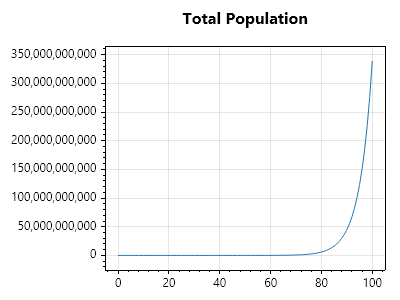
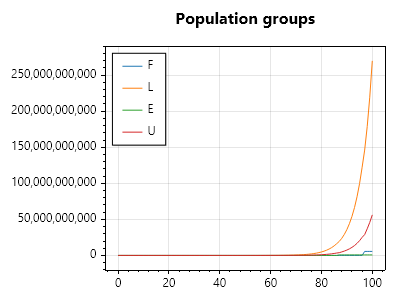
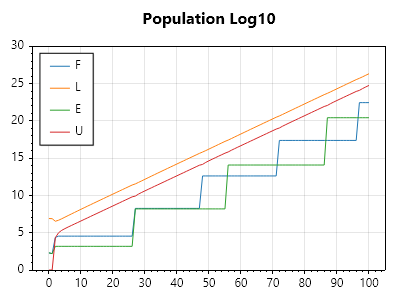
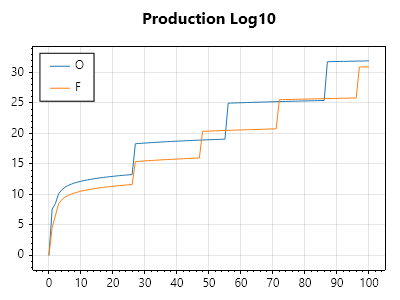
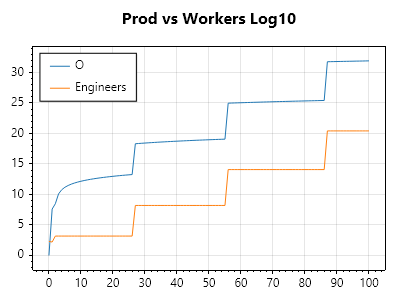

In [85]:
new [] {
    new PlotBuilder("Total Population").Add(populations.Select(pop => pop.Total)).Build()
    ,new PlotBuilder("Population groups").Add(populations.Select(pop => (pop.Farmers, pop.Laborers, pop.Engineers, pop.Unemployed)), ("F", "L", "E", "U")).Build()
    ,new PlotBuilder("Population Log10").Add(populations.Select(pop => (log(pop.Farmers), log(pop.Laborers), log(pop.Engineers), log(pop.Unemployed))), ("F", "L", "E", "U")).LimitH(30).Build()
    ,new PlotBuilder("Production Log10").Add(markets.Select(m => (log(m.Oxygen), log(m.Food))), ("O", "F")).Build()
    ,new PlotBuilder("Prod vs Workers Log10").Add(markets.Select((m, i) => (log(m.Oxygen), log(populations[i].Engineers))), ("O", "Engineers")).Build()
}

#### Declines

In [29]:
List<int> declines = Enumerable.Range(0, steps.Count - 1).Where((i) => steps[i].Population.Total > steps[i + 1].Population.Total).ToList();

new object[] {$"Simulation Completed with {declines.Count} declines", steps.Last().Population.Total, steps.Last().Population, steps.Last().Market, declines.Select(i => new [] {populations[i], populations[i + 1]})}

index type value 0 System.String Simulation Completed with 2 declines 1 System.Single 3.3912154E+11 2 Submission#23+Population Submission#23+Population Total 3.3912154E+11 Farmers 5.589834E+09 Laborers 2.6978062E+11 Engineers 738552260 Children 6.779719E+09 Unemployed 5.6232792E+10 3 Submission#23+Market Submission#23+Market Food 2.7194544E+13 Oxygen 7.186113E+13 Minerals 2.5713546E+14 Water 1.4372227E+13 4 System.Linq.Enumerable+SelectListIterator<System.Int32,Submission#23+Population[]> index value 0 index value 0 Submission#23+Population Total 1020 Farmers 10 Laborers 1000 Engineers 10 Children 0 Unemployed 0 1 Submission#23+Population Total 1018 Farmers 9 Laborers 980 Engineers 9 Children 20 Unemployed 0 1 index value 0 Submission#23+Population Total 1018 Farmers 9 Laborers 980 Engineers 9 Children 20 Unemployed 0 1 Submission#23+Population Total 888 Farmers 79 Laborers 692 Engineers 24 Children 17 Unemployed 76

## Markets

$\Delta price = $  goes up when supply is met, goes down when not 

# Politics

## What do i want
I want representation and discourse, disagreement.
I want it to be local and state wide. 

Beurocracy is a mess, but necessary 

## How do we get it 

Decisision should be based on local factors as geography and populations.
It should be implemented as representatives from different governments.


Three tier of government like NUTS


Ideas 

- Expertise do it by adding 1 saying output = 1 + expertise * 0.01
  - Chain it to some population, where it will be hard to promote to the expertise level 
  - You could also do it so that its proportional to the tola workforce, so a big population cant also have high expertise,  
    but rather it takes time for them to gain that much 
- Robots, automation
  - asf
- Market


# Hotkeys  
- `A`, `B` front and back
- `ESC`, `ENTER` writing or commands
- `M`, `Y` md and code 
